# Training the REAL/FAKE classifier

In [1]:
from fastai.core import *
from fastai.vision import *
from efficientnet_pytorch import EfficientNet

In [2]:
path = Path('../data/cropped_faces/')
src = ImageList.from_folder(path).split_by_folder(train='train', valid='valid')

In [3]:
def get_data(bs,size):
    data = (src.label_from_re('([A-Z]+).jpg$')
           .transform(get_transforms(max_warp=0, max_zoom=1), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

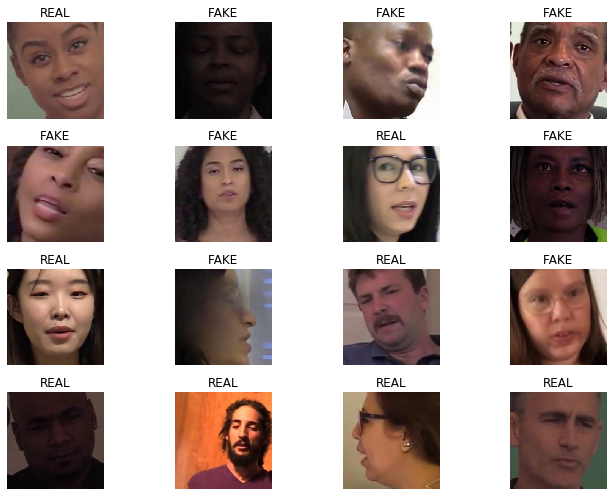

In [4]:
bs, sz = 32, 256
data = get_data(bs, sz)
data.show_batch(rows=4, figsize=(10,7))

## Resnet

In [ ]:
model = models.resnet18(num_classes=2)

In [ ]:
import copy

In [ ]:
fc = copy.deepcopy(model.fc)

In [ ]:
model.fc = nn.Identity()

In [ ]:
state_dict = torch.load('models/resnet_oselect_dfdc.pth')
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [ ]:
model.fc = fc

In [ ]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
learn = Learner(data, model, path='./', metrics=[accuracy])

In [ ]:
learn.lr_find(start_lr=1e-11, end_lr=1e-7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


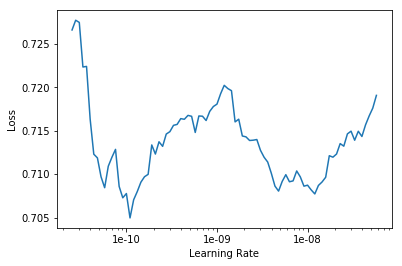

In [ ]:
learn.recorder.plot(skip_end=5)

In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.711658,0.714238,0.500000,00:43
1,0.710710,0.706583,0.522500,00:41
2,0.703991,0.704125,0.492500,00:41
3,0.703532,0.702864,0.472500,00:43
4,0.700790,0.702296,0.485000,00:44


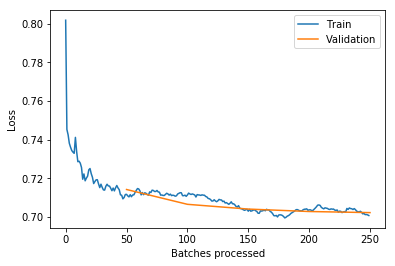

In [ ]:
learn.recorder.plot_losses()

## EfficientNetB0

### Transfer from Imagenet

In [65]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)


Loaded pretrained weights for efficientnet-b0


In [66]:
learn = Learner(data, model, metrics=[accuracy])

In [67]:
#fm = flatten_model(model)
#learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [68]:
#learn.freeze_to(-1)

In [69]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


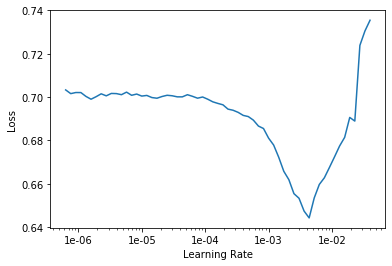

In [70]:
learn.recorder.plot(skip_end=15)

In [71]:
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.669000,0.705785,0.522500,00:12
1,0.546166,0.796264,0.572500,00:12
2,0.382067,0.801120,0.587500,00:12
3,0.297392,0.890991,0.655000,00:12
4,0.218553,1.139411,0.700000,00:12
5,0.220932,2.162415,0.622500,00:12
6,0.183045,1.362391,0.675000,00:12
7,0.143896,1.159336,0.665000,00:12
8,0.101916,1.913083,0.682500,00:12
9,0.089704,1.098780,0.685000,00:12


In [72]:
learn.save('effnetb0_classifier_ftimagenet')

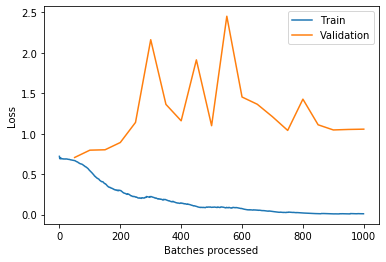

In [73]:
learn.recorder.plot_losses()

### Transfer from Online Selection

In [5]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.train_dl.c)



Loaded pretrained weights for efficientnet-b0


In [6]:
import copy

In [7]:
swish0 = copy.deepcopy(model._swish)
fc0 = copy.deepcopy(model._fc)
dropout0 = copy.deepcopy(model._dropout)

In [8]:
model._swish = nn.Identity()
model._fc = nn.Identity()
model._dropout = nn.Identity()

In [9]:
#state_dict = torch.load('models/effnetb0_oselect.pth')
state_dict = torch.load('models/effnetb0_otrpselect_margins_1_1_10cyc.pth')

In [10]:
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [11]:
model._swish = swish0
model._fc = fc0
model._dropout = dropout0

In [12]:
learn = Learner(data, model, metrics=[accuracy])

In [13]:
#fm = flatten_model(model)
#learn.layer_groups = [nn.Sequential(*fm[:-3]), nn.Sequential(*fm[-3:])]

In [14]:
#learn.freeze_to(-1)

In [15]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


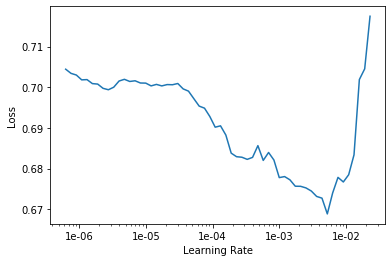

In [16]:
learn.recorder.plot(skip_end=20)

In [17]:
learn.fit_one_cycle(cyc_len=5, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.402961,0.398327,0.816915,08:04
1,0.268380,0.263892,0.887234,08:04
2,0.200594,0.275138,0.885792,08:05
3,0.150959,0.243145,0.903892,08:05
4,0.151209,0.246315,0.904533,08:04


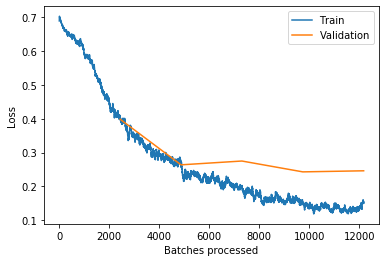

In [18]:
learn.recorder.plot_losses()

In [17]:
learn.save('effnetb0_classifier_otrpselect_margins_1_1_10cyc_20cyc')

# -fin